In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import lfilter, butter, find_peaks
import scipy

ModuleNotFoundError: No module named 'numpy'

In [ ]:
Fn = 360        # несущая частота
Fm = 10         # частота модулируемого сигнала
A = 1           # амплитуда Fn
quant = 512     # число уроовней квантования
Fn_phase = 0    # фаза модулирующего сигнала
Fm_phase = 0    # фаза модулирующего сигнала
t_end = 0.3     # время окончания модуляции сигнала
k_discr = 8     # отношение частоты дискретизации к частоте несущей
f_discr = Fn * k_discr # частота дискретизации
t_discr = 1 / f_discr  # период дискретизации
m = 1           # коэффициент модуляции 0 < m <= 1

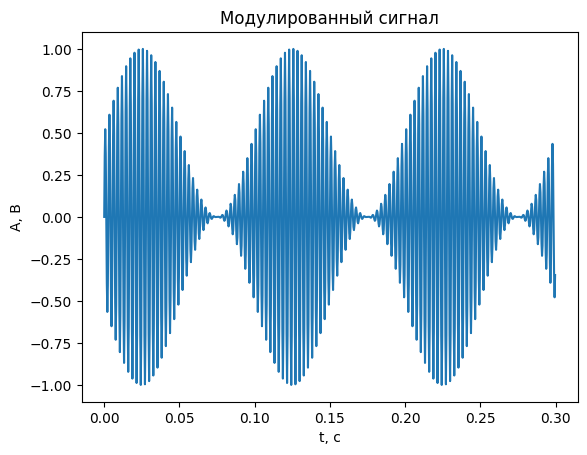

In [ ]:
def gen_mod_signal(t):
    return (1 + m * np.sin(2 * np.pi * Fm * t + Fm_phase)) \
        * A * np.sin(2 * np.pi * Fn * t + Fn_phase) * 1 / 2

t = np.arange(0, t_end, t_discr)
mod_signal = np.zeros(len(t))
for i in range(len(t)):
    mod_signal[i] = gen_mod_signal(t[i])

plt.xlabel('t, c')
plt.ylabel('A, В')
plt.title("Модулированный сигнал")
plt.plot(t, mod_signal)

### Дискретизация сигнала
Здесь выполняется дискретизация сигнала на интервале времени от 0 до заданного значения `t_end`. Модулированный сигнал генерируется для каждого значения времени, и результаты сохраняются в массив `mod_signal`.

In [ ]:
quant_sig = np.zeros(len(mod_signal))
for i in range(len(t)):
    quant_sig[i] = np.floor((mod_signal[i] + m) * quant / (2 * m))

### Построение графика модулированного сигнала
По оси X откладывается время, а по оси Y — амплитуда сигнала. Это позволяет визуально оценить поведение модулированного сигнала во времени.

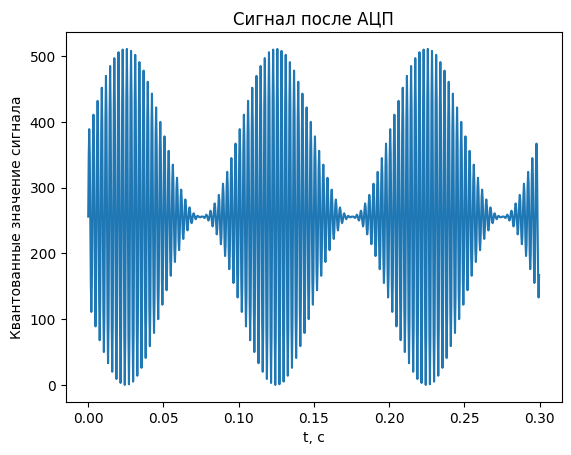

In [ ]:
plt.xlabel('t, c')
plt.ylabel('Квантованные значение сигнала')
plt.title("Сигнал после АЦП")
plt.plot(t, quant_sig)

### Квантование сигнала
Процесс квантования — это преобразование непрерывного сигнала в дискретный (с конечным числом уровней амплитуды). В данном случае квантование происходит на 512 уровней. Полученный квантованный сигнал будет использоваться для дальнейшего анализа.

In [ ]:
sin_buf1 = [quant_sig[i] * np.sin(i*2*np.pi*Fn/f_discr) for i in range(0, len(quant_sig))]
cos_buf1 = [quant_sig[i] * np.cos(i*2*np.pi*Fn/f_discr) for i in range(0, len(quant_sig))]

b, a = butter(2, Fm * k_discr/(2 * f_discr))
first_detection_2 = np.sqrt(lfilter(b, a, sin_buf1) ** 2 + lfilter(b, a, cos_buf1) ** 2)

C:\Users\Dafte\AppData\Local\Temp\ipykernel_57996\58761576.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


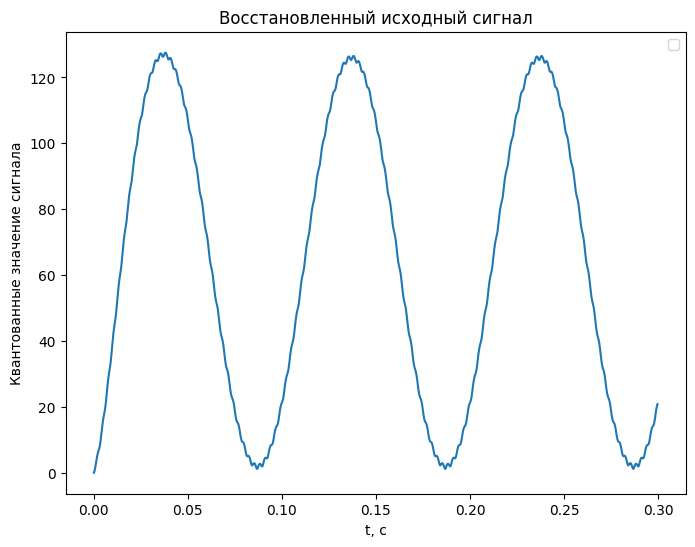

In [ ]:
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["legend.loc"] = 1
plt.xlabel('t, c')
plt.ylabel('Квантованные значение сигнала')
plt.title("Восстановленный исходный сигнал")
plt.legend()

plt.plot(t, first_detection_2, label="2 порядок")

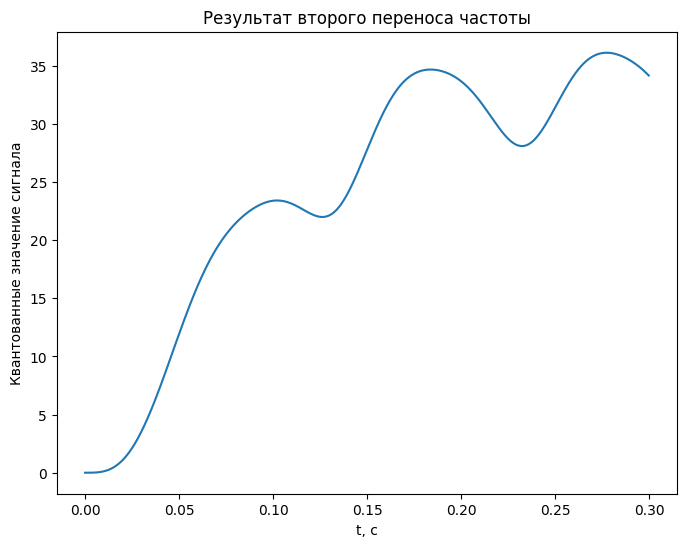

In [ ]:
sin_buf2_2 = [first_detection_2[i] * np.sin(i*2*np.pi*Fm/f_discr) \
              for i in range(0, len(quant_sig))]
cos_buf2_2 = [first_detection_2[i] * np.cos(i*2*np.pi*Fm/f_discr) \
              for i in range(0, len(quant_sig))]

b2, a2 = butter(2, Fm * k_discr/(2 *8* f_discr))

second_detection_2 = np.sqrt(lfilter(b2, a2, sin_buf2_2) ** 2 \
                             + lfilter(b2, a2, cos_buf2_2) ** 2)

plt.xlabel('t, c')
plt.ylabel('Квантованные значение сигнала')
plt.title("Результат второго переноса частоты")
plt.plot(t, second_detection_2, label="2 порядок")

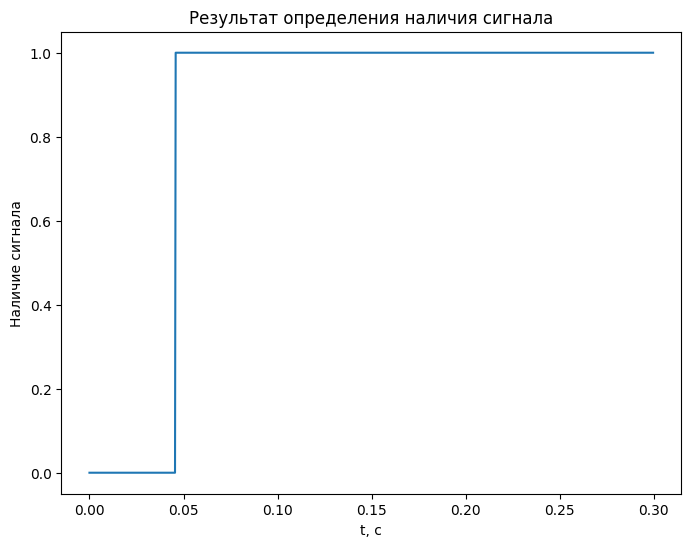

In [ ]:
lbound = 10
activation = [0 if second_detection_2[i] < lbound else 1 \
              for i in range(len(second_detection_2))]

plt.xlabel('t, c')
plt.ylabel('Наличие сигнала')
plt.title("Результат определения наличия сигнала")
plt.plot(t, activation, label="2 порядок")

In [ ]:
t[np.argmax(activation)]

np.float64(0.04583333333333334)

In [ ]:
Fn2 = Fn + 3 * Fm
mod_signal_2 = mod_signal + 0.5 * np.sin(2 * np.pi * Fn2 * t)

(360, 10)

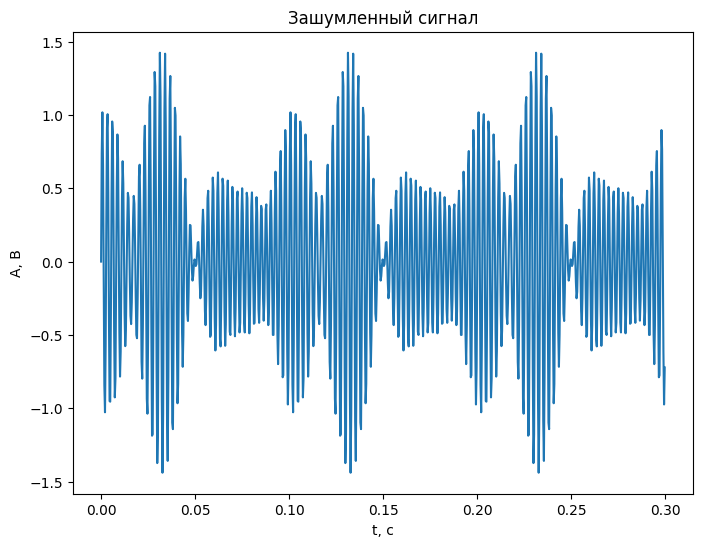

In [ ]:
plt.xlabel('t, c')
plt.ylabel('A, В')
plt.title("Зашумленный сигнал")
plt.plot(t, mod_signal_2)

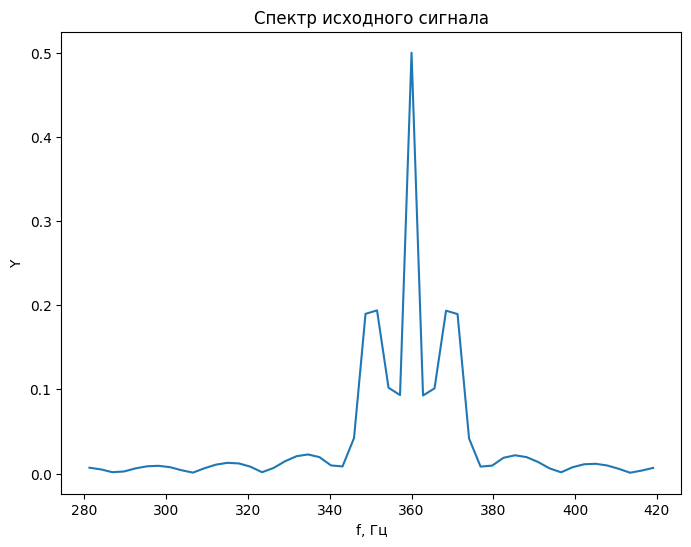

In [ ]:
spectrum_1 = abs(np.fft.fft(mod_signal, 1024))
spectrum_1 = spectrum_1 * 2 / len(t)
spectrum_1[0] = spectrum_1[0] / 2
freq = np.fft.fftfreq(1024, d=1 / f_discr)
plt.xlabel("f, Гц")
plt.ylabel("Y")
plt.title("Спектр исходного сигнала")
plt.plot(freq[100:150], spectrum_1[100:150])

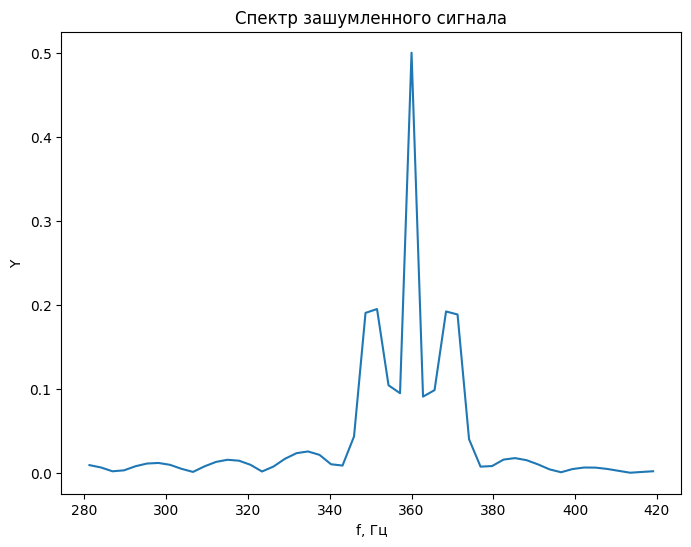

In [ ]:
spectrum_2 = abs(np.fft.fft(mod_signal_2, 1024))
spectrum_2 = spectrum_2 * 2 / len(t)
spectrum_2[0] = spectrum_2[0] / 2
freq = np.fft.fftfreq(1024, d=1 / f_discr)
plt.xlabel("f, Гц")
plt.ylabel("Y")
plt.title("Спектр зашумленного сигнала")
plt.plot(freq[100:150], spectrum_2[100:150])

In [ ]:
fr_1 = freq[find_peaks(spectrum_1, 0.15)[0]]
fr_2 = freq[find_peaks(spectrum_2, 0.15)[0]]
fr_1 = fr_1[fr_1 > 0]
fr_2 = fr_2[fr_2 > 0]
display(fr_1, fr_2)

array([351.5625, 360.    , 368.4375])

array([351.5625, 360.    , 368.4375, 390.9375])